# Mineração de Dados - 2018.2
----

## Dependências

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from itertools import groupby
from datetime import datetime
from sklearn.ensemble import IsolationForest

In [2]:
STR_FORMAT = '%Y-%m-%d %H:%M:%S'

## Métodos Auxiliares

In [3]:

def get_date(ts):
    date = datetime.fromtimestamp(ts).strftime(STR_FORMAT)
    return date


def drop_invalid_columns(df):
    colsdrop = ['Unnamed: 0', 'VAR19', 'VAR29', 'VAR30']
    df = df.drop(colsdrop, axis=1)
    return df


def get_redundant_pairs(df):
    '''Get diagonal and lower triangular pairs of correlation matrix'''
    pairs_to_drop = set()
    cols = df.columns
    for i in range(0, df.shape[1]):
        for j in range(0, i+1):
            pairs_to_drop.add((cols[i], cols[j]))
    return pairs_to_drop


def get_top_correlations(df, n=5, asc=False, absolute=False):
    au_corr = df.corr().abs().unstack() if absolute else df.corr().unstack()
    labels_to_drop = get_redundant_pairs(df)
    au_corr = au_corr.drop(labels=labels_to_drop).sort_values(ascending=asc)
    return au_corr[0:n]


ranges = {}
def normalize(df):
    result = df.copy()
    for feature_name in df.columns:
        max_value = df[feature_name].max()
        min_value = df[feature_name].min()
        ranges[feature_name] = (min_value, max_value)
        
        result[feature_name] = (df[feature_name] - min_value) / (max_value - min_value)
    return result

def denormalize(df):
    result = df.copy()
    for feature_name in df.columns:
        result[feature_name] = df[feature_name] * (ranges[feature_name][1] - ranges[feature_name][0]) + ranges[feature_name][0]
    return result

def get_anomalies(base, reprovados=False, contamination=0.1):
    # Base de dado com e sem headers
    sample = base.copy()
    sample.columns = range(sample.shape[1])
    
    #Isolation Forest
    clf = IsolationForest(max_samples='auto', contamination=contamination, n_jobs=-1)
    clf.fit(sample)
    
    # Deteccao de anomalias
    scores = clf.decision_function(sample)
    predict  = clf.predict(sample)
    num_outliers = predict.tolist().count(-1)
    
    outliers = []
    outliers_position = []
    while len(outliers) < num_outliers:
        outliers.append(scores.min())
        
        outliers_position.append(scores.argmin()+1)
        scores = np.delete(scores, scores.argmin())
    
    # Anomalias encontradas    
    anomalias = base.iloc[outliers_position]
    anomalias = anomalias.sort_values(
            by=['DESEMPENHO'],
            ascending=False
            )
    anomalias = anomalias.drop_duplicates()
    
    return anomalias

def anomalias_por_periodo(df_anomalia, title, ax):
    periodos = []
    for _, row in df_anomalia.iterrows():
        periodos.append(row["PERIODO"])

    periodos.sort()
    frequencia = [len(list(group)) for key, group in groupby(periodos)]
    periodos = list(set(periodos))
    
    ax.set_title(title)
    ax.set_xlabel('Período')
    ax.set_ylabel('Frequência')
    ax.set_xticks(np.arange(10))
    ax.bar(periodos, frequencia)

def bar_plot_series(serie, name, save=False):
    plt.figure(figsize=(20,10))
    serie.plot.bar()
    if save:
        plt.savefig('./Outputs/Figuras/'+name+'.svg', bbox_inches='tight')
        return
    plt.show()

def heatmap(df, title, ax):
    df = df.copy()
    df = df.drop("DESEMPENHO_BINARIO", axis=1)
    
    ax.set_title(title)
    corr = df.corr()
    sns.heatmap(
        corr,
        xticklabels=corr.columns,
        yticklabels=corr.columns,
        cmap="YlGnBu",
        linewidth=0.5,
        vmin=-1,
        vmax=1,
        ax=ax)


## Modelagem
----

In [4]:
# Carregar Dados

base = '../Base/Subsets/basePedagogia.csv'
df_base = pd.read_csv(base, sep=';', decimal=',', index_col=False)
df_base = drop_invalid_columns(df_base)

In [5]:
# Registros por disciplina

df_disciplinas = []
disciplinas = list(df_base["NOME_DA_DISCIPLINA"].drop_duplicates())
for d in disciplinas:
    df_disci = df_base.loc[df_base["NOME_DA_DISCIPLINA"]==d]
    registros = len(df_disci)
    if registros != 0:
        df_disciplinas.append((registros, d))
        
df_disciplinas = pd.DataFrame(df_disciplinas, columns=["registros", "disciplina"])
df_disciplinas = df_disciplinas.sort_values(
        by=["registros"],
        ascending=False
        )
nome_disciplina = df_disciplinas.iat[0,1]
df_disciplinas.head()

,registros,disciplina
22,871,Planejamento Educacional
19,788,Educação e Multiculturalismo
18,788,Currículo e Contemporaneidade
15,497,Movimentos Sociais
13,497,História da Educação no Brasil


In [6]:
# Seleção

df_base = df_base.sort_values(
        by=['VAR31', 'VAR24', 'DESEMPENHO'],
        ascending=False
        )

# Disciplina com mais registros
df_base = df_base.loc[df_base["NOME_DA_DISCIPLINA"]==nome_disciplina]
df_base.head(3)

,CURSO,SEMESTRE,PERIODO,NOME_DA_DISCIPLINA,ID_DA_DISCIPLINA,DATA_DE_INICIO,DATA_DE_FINAL,ID_DO_ALUNO,VAR01,VAR02,...,FORUM04,MEDIA_FORUM,WEBQUEST01,WEBQUEST02,MEDIA_WEBQUEST,DESEMPENHO,DESEMPENHO_BINARIO,MEDIA_CALCULADA_PROVA,MEDIA_CALCULADA_FORUM,TEMPO_DE_CURSO
3385,Pedagogia,2012.1,4,Planejamento Educacional,52,2011-12-31 21:00:00,2012-06-30 20:59:59,133,39,0,...,4,0.8,5,4,1.125,3.440,1,2.750,4.00,181 days 23:59:59.000000000
8160,Pedagogia,2014.1,4,Planejamento Educacional,48,2013-12-31 21:00:00,2014-06-30 20:59:59,568,4,0,...,0,1.5,0,0,0.000,4.250,0,2.750,3.75,180 days 23:59:59.000000000
13197,Pedagogia,2016.1,4,Planejamento Educacional,61,2015-12-31 21:00:00,2016-06-30 20:59:59,1826,87,3,...,5,2.0,4,5,2.250,7.825,0,3.575,5.00,181 days 23:59:59.000000000


In [7]:
print("Registros: Total - {} | Aprovados - {} | Reprovados - {}".format(
    len(df_base),
    len(df_base.loc[df_base["DESEMPENHO_BINARIO"] == 0]), 
    len(df_base.loc[df_base["DESEMPENHO_BINARIO"] == 1]))
     )

Registros: Total - 871 | Aprovados - 324 | Reprovados - 547


### - Variaveis de Interesse
---
| Variável        | Significado | Categoria |
| --------------- | ----------- | --------- |
| VAR02           | Quantidade de mensagens enviadas por aluna(o) às(os) Professoras(es) pelo ambiente.  | Busca por Ajuda
| VAR03           | Quantidade de mensagens enviadas por aluna(o) às(os) Tutor(es) pelo ambiente.        | Busca por Ajuda
| VAR04           | Quantidade geral de mensagens enviadas pela(o) aluna(o) dentro do ambiente.          | Busca por Ajuda
| VAR06           | Quantidade de tópicos criados pelo(a) aluno(a) em fórum do tipo "tira-dúvidas".      | Busca por Ajuda
| VAR07           | Quantidade de postagens no "Fórum tira dúvidas".                                     | Busca por Ajuda
| VAR16           | Quantidade de atividades entregues por um(a) aluno(a) fora do prazo, por disciplina. | Estratégia de Realização de Tarefa
| VAR18           | Quantidade de leituras feitas ao fórum (pageviews).                                  | Estratégia de Realização de Tarefa
| VAR20           | Quantidade de respostas ao tópico principal (refazer opinião em fórum).              | Autoavaliação
| VAR24           | Média semanal da quantidade de acessos de um(a) aluno(a) ao ambiente.                | Gestão do Tempo
| VAR31           | Quantidade de acessos do(a) aluno(a) ao ambiente.                                    | Gestão do Tempo
| VAR33           | Quantidade de atividades entregues por um(a) aluno(a) no prazo, por disciplina.      | Estabelecimento de metas
| VAR34           | Quantidade geral de postagens de um(a) aluno(a) em fóruns.                           | Estabelecimento de metas
| DESEMPENHO      | 0.55\*MEDIA_PROVAS + 0.2\*MEDIA_FORUM + 0.25\*MEDIA_WEBQUEST                         | Avaliação

In [8]:
df_clean = df_base[['VAR02', 'VAR03', 'VAR04','VAR06', 'VAR07', 'VAR16','VAR18', 'VAR20',
                   'VAR24', 'VAR31', 'VAR33', 'VAR34', 'MEDIA_PROVAS', 'MEDIA_FORUM', 
                   'MEDIA_WEBQUEST', 'DESEMPENHO', 'DESEMPENHO_BINARIO']]
df_clean.head(3)

,VAR02,VAR03,VAR04,VAR06,VAR07,VAR16,VAR18,VAR20,VAR24,VAR31,VAR33,VAR34,MEDIA_PROVAS,MEDIA_FORUM,MEDIA_WEBQUEST,DESEMPENHO,DESEMPENHO_BINARIO
3385,0,0,29,0,0,1,133,0,13.0,355,1,4,1.510,0.8,1.125,3.440,1
8160,0,1,36,0,0,0,47,0,13.0,346,1,4,2.750,1.5,0.000,4.250,0
13197,3,24,52,0,0,0,117,0,13.0,344,2,6,3.575,2.0,2.250,7.825,0


## Análise
----

### - Normalização

In [9]:
df_clean_norm = normalize(df_clean)
df_clean_norm.head(3)

,VAR02,VAR03,VAR04,VAR06,VAR07,VAR16,VAR18,VAR20,VAR24,VAR31,VAR33,VAR34,MEDIA_PROVAS,MEDIA_FORUM,MEDIA_WEBQUEST,DESEMPENHO,DESEMPENHO_BINARIO
3385,0.00,0.000000,0.367089,0.0,0.0,1.0,0.930070,0.0,1.0,1.000000,0.5,0.285714,0.274545,0.40,0.375,0.327619,1.0
8160,0.00,0.041667,0.455696,0.0,0.0,0.0,0.328671,0.0,1.0,0.974648,0.5,0.285714,0.500000,0.75,0.000,0.404762,0.0
13197,0.75,1.000000,0.658228,0.0,0.0,0.0,0.818182,0.0,1.0,0.969014,1.0,0.428571,0.650000,1.00,0.750,0.745238,0.0


### - Detecção de Anomalias

In [10]:
anomalias_norm = get_anomalies(df_clean_norm, contamination=0.05)
print("Anomalias: Aprovados - {} | Reprovados - {}".format(
    len(anomalias_norm.loc[anomalias_norm["DESEMPENHO_BINARIO"] == 0]), 
    len(anomalias_norm.loc[anomalias_norm["DESEMPENHO_BINARIO"] == 1]))
     )

Anomalias: Aprovados - 26 | Reprovados - 12


## Visualização
----

In [11]:
# Remoção de anomalias no subset
idxc = df_clean_norm.index
idxa = anomalias_norm.index
idxs = idxc.difference(idxa)

df_clean_norm = df_clean_norm.loc[idxs]

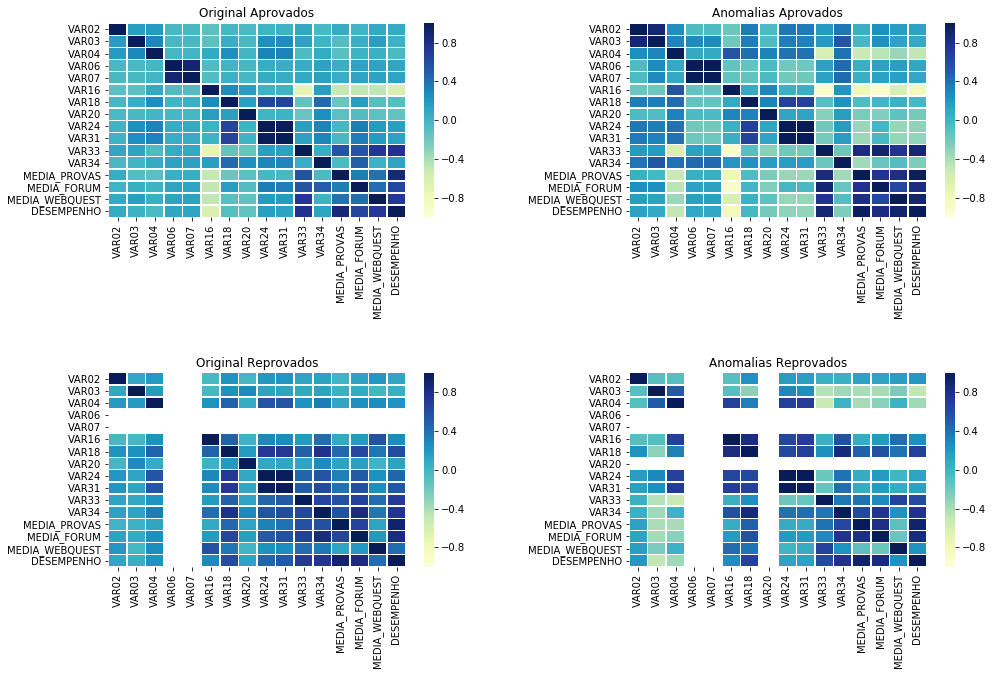

In [12]:
# Heatmap
f, (ax1, ax2) = plt.subplots(2, 2, figsize=(16,10))
plt.subplots_adjust(wspace=0.4, hspace=0.8)
heatmap(df_clean_norm.loc[df_clean_norm["DESEMPENHO_BINARIO"] == 0], "Original Aprovados", ax1[0])
heatmap(anomalias_norm.loc[anomalias_norm["DESEMPENHO_BINARIO"] == 0], "Anomalias Aprovados", ax1[1])

heatmap(df_clean_norm.loc[df_clean_norm["DESEMPENHO_BINARIO"] == 1], "Original Reprovados", ax2[0])
heatmap(anomalias_norm.loc[anomalias_norm["DESEMPENHO_BINARIO"] == 1], "Anomalias Reprovados", ax2[1])

### Anomalias

In [13]:
# Desnormalização
anomalias_denorm = denormalize(anomalias_norm)
anomalias_denorm.head(3)

,VAR02,VAR03,VAR04,VAR06,VAR07,VAR16,VAR18,VAR20,VAR24,VAR31,VAR33,VAR34,MEDIA_PROVAS,MEDIA_FORUM,MEDIA_WEBQUEST,DESEMPENHO,DESEMPENHO_BINARIO
13332,1.0,0.0,12.0,0.0,0.0,0.0,22.0,0.0,5.0,140.0,2.0,4.0,5.5,2.0,3.00,10.50,0.0
13241,0.0,0.0,0.0,0.0,0.0,0.0,36.0,0.0,3.0,93.0,2.0,4.0,5.5,1.9,3.00,10.40,0.0
13266,0.0,0.0,0.0,0.0,0.0,0.0,103.0,0.0,7.0,182.0,2.0,4.0,5.5,2.0,2.75,10.25,0.0


In [14]:
nome_disciplina = nome_disciplina.replace(' ', '')
df_anomalia = df_base.loc[anomalias_denorm.index]
df_anomalia.to_csv('../Base/Subsets/Anomalias/anomaliasPedagogiaDisciplina{}.csv'.format(nome_disciplina), sep=';', decimal=',')
df_anomalia.sort_values(
    by=["DESEMPENHO"], 
    ascending=False
    ).head(10)


,CURSO,SEMESTRE,PERIODO,NOME_DA_DISCIPLINA,ID_DA_DISCIPLINA,DATA_DE_INICIO,DATA_DE_FINAL,ID_DO_ALUNO,VAR01,VAR02,...,FORUM04,MEDIA_FORUM,WEBQUEST01,WEBQUEST02,MEDIA_WEBQUEST,DESEMPENHO,DESEMPENHO_BINARIO,MEDIA_CALCULADA_PROVA,MEDIA_CALCULADA_FORUM,TEMPO_DE_CURSO
13332,Pedagogia,2016.1,4,Planejamento Educacional,61,2015-12-31 21:00:00,2016-06-30 20:59:59,1709,18,1,...,5,2.0,6,6,3.00,10.500,0,5.500,5.00,181 days 23:59:59.000000000
13241,Pedagogia,2016.1,4,Planejamento Educacional,61,2015-12-31 21:00:00,2016-06-30 20:59:59,1652,18,0,...,5,1.9,6,6,3.00,10.400,0,5.500,4.75,181 days 23:59:59.000000000
13266,Pedagogia,2016.1,4,Planejamento Educacional,61,2015-12-31 21:00:00,2016-06-30 20:59:59,1731,54,0,...,5,2.0,5,6,2.75,10.250,0,5.500,5.00,181 days 23:59:59.000000000
13274,Pedagogia,2016.1,4,Planejamento Educacional,61,2015-12-31 21:00:00,2016-06-30 20:59:59,1769,6,0,...,5,2.0,5,6,2.75,9.975,0,5.225,5.00,181 days 23:59:59.000000000
13130,Pedagogia,2016.1,4,Planejamento Educacional,61,2015-12-31 21:00:00,2016-06-30 20:59:59,1931,13,0,...,5,2.0,6,5,2.75,9.975,0,5.225,5.00,181 days 23:59:59.000000000
13178,Pedagogia,2016.1,4,Planejamento Educacional,61,2015-12-31 21:00:00,2016-06-30 20:59:59,1947,5,0,...,5,2.0,6,5,2.75,9.975,0,5.225,5.00,181 days 23:59:59.000000000
13310,Pedagogia,2016.1,4,Planejamento Educacional,61,2015-12-31 21:00:00,2016-06-30 20:59:59,1660,6,0,...,4,1.7,4,5,2.25,9.450,0,5.500,4.25,181 days 23:59:59.000000000
13349,Pedagogia,2016.1,4,Planejamento Educacional,61,2015-12-31 21:00:00,2016-06-30 20:59:59,1767,11,0,...,0,1.5,4,5,2.25,8.700,0,4.950,3.75,181 days 23:59:59.000000000
13339,Pedagogia,2016.1,4,Planejamento Educacional,61,2015-12-31 21:00:00,2016-06-30 20:59:59,1868,23,0,...,5,1.9,4,6,2.50,8.525,0,4.125,4.75,181 days 23:59:59.000000000
13165,Pedagogia,2016.1,4,Planejamento Educacional,61,2015-12-31 21:00:00,2016-06-30 20:59:59,1856,42,0,...,5,1.9,5,5,2.50,8.525,0,4.125,4.75,181 days 23:59:59.000000000
